# Filter Duplicates

In [78]:
# read metadata
import json
with open('../../data/metadata_postgres_with_licenses.json', 'r') as f:
    metadata = json.load(f)

In [79]:
# remove duplicates
duplicates = 0
seen_tables = set()
datasets = list(metadata.keys())
for dataset in datasets:
    tables_str =  str(metadata[dataset]["TABLES"])
    if tables_str in seen_tables:
        duplicates += 1
        del metadata[dataset]
        continue
    
    seen_tables.add(tables_str)

print(f"duplicates removed: {duplicates}/{len(datasets)}")

duplicates removed: 11892/61038


In [81]:
# save deduplicated metadata
with open('../../data/metadata_postgres_with_licenses_deduplicated.json', 'w') as f:
    json.dump(metadata, f)

# Create Statistics

In [109]:
open_licenses = ["mit", "apache-2.0"]
only_for_open_licenses = True

In [110]:
datasets = 0
tables = 0
column_names = []
pks = 0
pk_composites = []
pk_names = []
pk_counts = []
fks = 0
fk_counts = []
fk_names = []
fk_ref_names = []
fk_full_ref_names = []
licenses = []
for dataset in metadata.keys():
    if only_for_open_licenses and metadata[dataset]["INFO"]["license"] not in open_licenses:
        continue
    datasets += 1
    tables += len(metadata[dataset]["TABLES"])
    licenses.append(metadata[dataset]["INFO"]["license"])
    for table in metadata[dataset]["TABLES"].keys():
        column_names.extend([col[0] for col in metadata[dataset]["TABLES"][table]["COLUMNS"]])          
        pks += len(metadata[dataset]["TABLES"][table]["PRIMARY_KEYS"])
        pk_names.extend(metadata[dataset]["TABLES"][table]["PRIMARY_KEYS"])
        pk_counts.append(len(metadata[dataset]["TABLES"][table]["PRIMARY_KEYS"]))
        pk_composites.append(', '.join(metadata[dataset]["TABLES"][table]["PRIMARY_KEYS"]))
        fks += len(metadata[dataset]["TABLES"][table]["FOREIGN_KEYS"])
        fk_counts.append(len([k['FOREIGN_KEY'] for k in metadata[dataset]["TABLES"][table]["FOREIGN_KEYS"]]))
        fk_names.extend([k['FOREIGN_KEY'] for k in metadata[dataset]["TABLES"][table]["FOREIGN_KEYS"]])
        for fk in metadata[dataset]["TABLES"][table]["FOREIGN_KEYS"]:
            rt = fk['REFERENCE_TABLE']
            rcs = fk['REFERENCE_COLUMN']
            for rc in rcs:
                fk_full_ref_names.append(f"{rt}.{rc}")
        fk_ref_names.extend([k['REFERENCE_COLUMN'] for k in metadata[dataset]["TABLES"][table]["FOREIGN_KEYS"]])
    if datasets % 10000 == 0 or datasets == len(metadata.keys()):
        print(f"datasets: {datasets}, tables: {tables}, columns: {len(column_names)}, primary_keys: {pks}, foreign_keys: {fks}", end="\r")

print(f"datasets: {datasets}, tables: {tables}, columns: {len(column_names)}, primary_keys: {pks}, foreign_keys: {fks}", end="\r")        

# ALL:
# datasets: 49146, tables: 323953, columns: 2054026, primary_keys: 248187, foreign_keys: 142421, duplicates: 11892
#
# WITH OPEN LICENSE:
# datasets: 6642, tables: 51594, columns: 363420, primary_keys: 36620, foreign_keys: 24380

In [111]:
fk_counts_per_table = []
fk_names_flat = []
for fks in fk_names:
    fk_counts_per_table.append(len(fks))
    for fk in fks:
        fk_names_flat.append(fk)
        
fk_ref_names_flat = []
for fks in fk_ref_names:
    for fk in fks:
        fk_ref_names_flat.append(fk)

In [112]:
from matplotlib import pyplot as plt
import collections

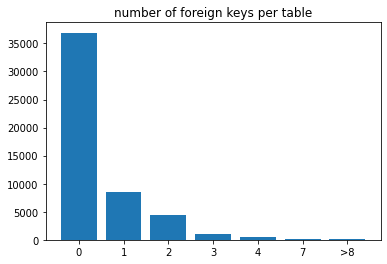

In [113]:
# fk's per table
counter = collections.Counter(fk_counts)
most_common = counter.most_common()

cutoff = 6
most_common[cutoff] = (f">{most_common[cutoff][0]}", sum([kv[1] for kv in most_common[cutoff:]]))
most_common = most_common[:cutoff+1]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("number of foreign keys per table")
plt.bar(x, y)
plt.show()

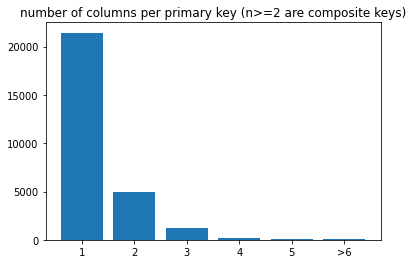

In [114]:
# composite pks per table
counter = collections.Counter(pk_counts)
most_common = counter.most_common()
most_common = sorted(most_common, key=lambda x: x[0])

cutoff = 6
most_common[cutoff] = (f">{most_common[cutoff][0]}", sum([kv[1] for kv in most_common[cutoff:]]))
most_common = most_common[1:cutoff+1]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("number of columns per primary key (n>=2 are composite keys)")
plt.bar(x, y)
plt.show()

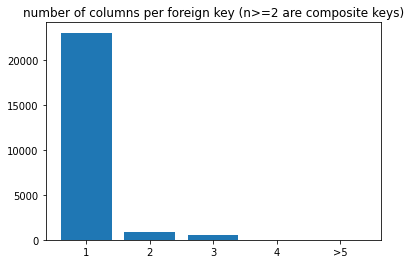

In [115]:
# composite fks per table
counter = collections.Counter(fk_counts_per_table)
most_common = counter.most_common()

most_common = sorted(most_common, key=lambda x: x[0])

cutoff = 4
most_common[cutoff] = (f">{most_common[cutoff][0]}", sum([kv[1] for kv in most_common[cutoff:]]))
most_common = most_common[0:cutoff+1]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("number of columns per foreign key (n>=2 are composite keys)")
plt.bar(x, y)
plt.show()

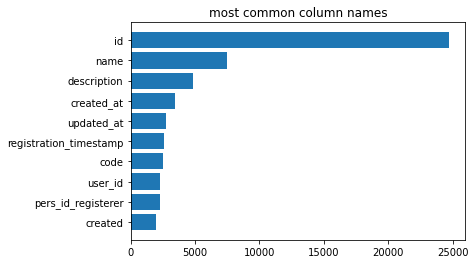

In [116]:
# column nmaes
counter = collections.Counter(column_names)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common column names")
plt.barh(x[::-1], y[::-1])
plt.show()

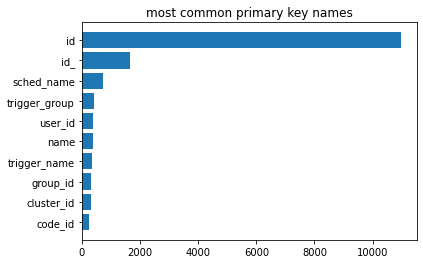

In [117]:
# primary keys names
counter = collections.Counter(pk_names)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common primary key names")
plt.barh(x[::-1], y[::-1])
plt.show()

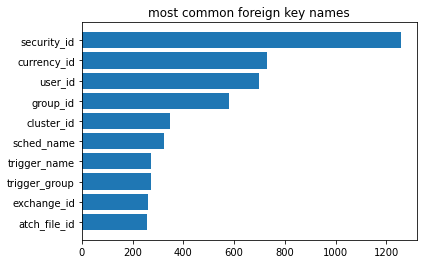

In [118]:
# foreign key names
counter = collections.Counter(fk_names_flat)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common foreign key names")
plt.barh(x[::-1], y[::-1])
plt.show()

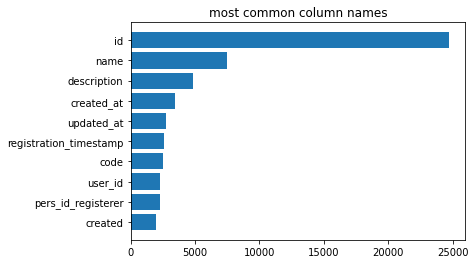

In [119]:
# column nmaes
counter = collections.Counter(column_names)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common column names")
plt.barh(x[::-1], y[::-1])
plt.show()

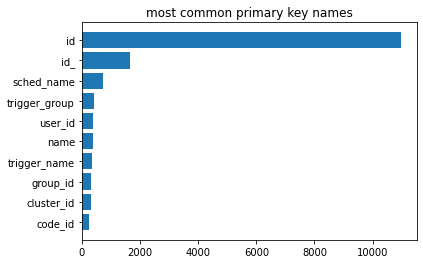

In [120]:
# primary keys names
counter = collections.Counter(pk_names)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common primary key names")
plt.barh(x[::-1], y[::-1])
plt.show()

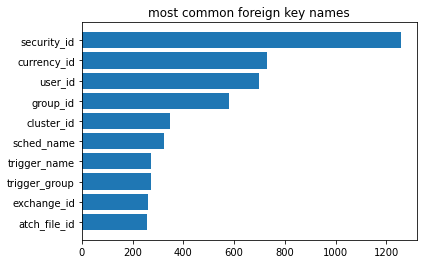

In [139]:
# foreign key names
counter = collections.Counter(fk_names_flat)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common foreign key names")
plt.barh(x[::-1], y[::-1])
plt.show()

In [122]:
# foreign keys reference names with table name
counter = collections.Counter(fk_full_ref_names)
print(len(counter))
counter.most_common()[:10]

6528


[('sec_currency.id', 1547),
 ('sec_security.id', 1297),
 ('users.id', 547),
 ('sec_exchange.id', 492),
 ('sec_frequency.id', 455),
 ('comtnauthorgroupinfo.group_id', 369),
 ('comtnauthorinfo.author_code', 361),
 ('comtnfile.atch_file_id', 252),
 ('qrtz_triggers.trigger_name', 242),
 ('qrtz_triggers.trigger_group', 242)]

In [123]:
# foreign keys reference names
counter = collections.Counter(fk_ref_names_flat)
print(len(counter))

counter.most_common()[:10]

2051


[('id', 13506),
 ('group_id', 512),
 ('author_code', 365),
 ('cluster_id', 334),
 ('sched_name', 323),
 ('trigger_name', 274),
 ('trigger_group', 274),
 ('user_id', 272),
 ('atch_file_id', 256),
 ('name', 217)]

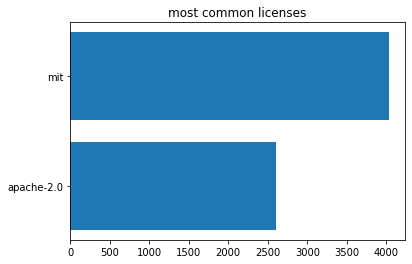

In [124]:
# most common licenses
counter = collections.Counter(licenses)
most_common = counter.most_common()

cutoff = 10
most_common = most_common[0:cutoff]
                          
x = [str(kv[0]) for kv in most_common]
y = [kv[1] for kv in most_common]

plt.title("most common licenses")
plt.barh(x[::-1], y[::-1])
plt.show()

In [125]:
open_licenses = ["mit", "apache-2.0"]
open_license_count = sum([counter[license] for license in open_licenses])
all_license_count = sum(counter.values())
print(f"mit+apache2.0: {open_license_count}/{all_license_count-open_license_count}")

mit+apache2.0: 6642/0


# Overlap with Webtables

In [126]:
# download headerDistri_list from http://data.dws.informatik.uni-mannheim.de/webtables/2015-07/statistics/relational/headerDistri_list.txt
colnames_webtables = set()
with open('../../data/headerDistri_list.txt', mode="r", encoding="utf-8") as f:
    for line in f:
        colname = line.split(" Value : ")[0].replace("Key : ", "")
        colnames_webtables.add(colname)

In [131]:
matches = 0
top_matches = []
top_non_matches = []
for col_name in column_names:
    if col_name in colnames_webtables:
        matches += 1
        top_matches.append(col_name)
    else:
        top_non_matches.append(col_name)
        
print(f"matches per table: {matches}/{len(column_names)}")
print(f"matches per unique column name: {len(set(top_matches))}/{len(set(column_names))}")

matches per table: 133277/363420
matches per unique column name: 4752/55157


In [136]:
counter = collections.Counter(top_matches)
most_common = counter.most_common()
cutoff = 50
most_common[cutoff] = (f"others", sum([kv[1] for kv in most_common[cutoff:]]))
most_common = most_common[:cutoff+1]
most_common

[('id', 24740),
 ('name', 7447),
 ('description', 4865),
 ('created_at', 3475),
 ('updated_at', 2733),
 ('code', 2554),
 ('user_id', 2318),
 ('created', 1934),
 ('version', 1832),
 ('value', 1654),
 ('status', 1541),
 ('email', 1461),
 ('updated', 1337),
 ('title', 1189),
 ('password', 1084),
 ('type', 1084),
 ('group_id', 991),
 ('username', 912),
 ('label', 769),
 ('currency_id', 757),
 ('state', 663),
 ('deleted', 618),
 ('first_name', 608),
 ('last_name', 592),
 ('type_', 587),
 ('content', 508),
 ('url', 487),
 ('zip', 475),
 ('ordinal', 439),
 ('city', 438),
 ('strike', 430),
 ('start_date', 428),
 ('uuid', 419),
 ('active', 415),
 ('address', 404),
 ('key', 403),
 ('amount', 398),
 ('user_name', 367),
 ('role', 366),
 ('is_mandatory', 351),
 ('data', 349),
 ('is_public', 346),
 ('country', 345),
 ('date', 344),
 ('project_id', 338),
 ('price', 332),
 ('priority', 331),
 ('start_time', 327),
 ('created_on', 327),
 ('request_id', 326),
 ('others', 55839)]

In [138]:
counter = collections.Counter(top_non_matches)
most_common = counter.most_common()
cutoff = 500
most_common[cutoff] = (f"others", sum([kv[1] for kv in most_common[cutoff:]]))
most_common = most_common[:cutoff+1]
most_common

[('registration_timestamp', 2628),
 ('pers_id_registerer', 2318),
 ('id_', 1734),
 ('modification_timestamp', 1638),
 ('rev_', 1322),
 ('security_id', 1260),
 ('frst_regist_pnttm', 1181),
 ('last_updt_pnttm', 1177),
 ('last_updusr_id', 1177),
 ('frst_register_id', 1176),
 ('dbin_id', 1116),
 ('name_', 938),
 ('tenant_id_', 895),
 ('sched_name', 821),
 ('cluster_id', 803),
 ('createdAt', 731),
 ('use_at', 675),
 ('proc_def_id_', 665),
 ('created_by', 655),
 ('expiry_date', 638),
 ('pers_id_author', 626),
 ('expiry_zone', 606),
 ('expiry_accuracy', 606),
 ('execution_id_', 592),
 ('expe_id', 590),
 ('is_managed_internally', 581),
 ('updatedAt', 580),
 ('proc_inst_id_', 575),
 ('trigger_group', 551),
 ('underlying_scheme', 500),
 ('underlying_identifier', 500),
 ('samp_id', 500),
 ('trigger_name', 473),
 ('atch_file_id', 467),
 ('service_name', 449),
 ('create_time', 424),
 ('option_exercise_type', 416),
 ('area_no', 409),
 ('sbscrb_de', 390),
 ('detail_adres', 388),
 ('createdby', 381),


In [154]:
# foreign keys, related to orders
order_fks = [x for x in sorted(list(counter.keys())) if "ord" in x.lower()]
order_fks

['OrderID',
 'OrderId',
 'audit_record_id',
 'buy_order_id',
 'buyrecordid',
 'cktraitwordid',
 'cod_orgao_subordinado',
 'cord_ref',
 'customer_order_id',
 'discord_user_id',
 'drug_record_id',
 'electronic_order_id',
 'forgotpassword_questions_id',
 'from_word_id',
 'id_ord',
 'id_order',
 'indicatordescriptorid',
 'keywordid',
 'l_orderkey',
 'liga_uebergeordnet',
 'line_order_number',
 'marc_type_of_record_id',
 'metabolite_record_id',
 'negative_words_id',
 'order_code_id',
 'order_customer_number',
 'order_delivery_method_id',
 'order_detail_id',
 'order_id',
 'order_info_id',
 'order_ref',
 'order_shipping_method_id',
 'orderdatekey',
 'orderid',
 'ordernumber',
 'orders_customer_cno',
 'orders_product_pno',
 'ordr_id',
 'password_id',
 'positive_words_id',
 'record_hash',
 'record_id',
 'region_uebergeordnet',
 'salerecordid',
 'sales_order_change_log_id',
 'sales_order_confirmation_status_id',
 'sales_order_delivery_group_id',
 'sales_order_delivery_group_id_left',
 'sales_ord

In [163]:
# number of those fk's present in webtables
[fk for fk in order_fks if fk in colnames_webtables]

['OrderID', 'OrderId', 'order_id', 'orderid']